In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

In [2]:
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
        
    def gradient(self,t,x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F    

    def jacobian(self, x):
        m = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    m[i][j] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    m[i][j] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    m[i][j] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    m[i][j] -= 1
        return m
        
    
class RK4:
    def __init__(self, N, dt):
        self.N = N
        self.dt = dt

    def nextstep(self, gradient, t, x):
        k1 = handler(gradient, t, x)
        k2 = handler(gradient, t + self.dt/2, x + k1*self.dt/2)
        k3 = handler(gradient, t + self.dt/2, x + k2*self.dt/2)
        k4 = handler(gradient, t + self.dt  , x + k3*self.dt)
        return x + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
    
    def orbit(self, gradient, t0, x0, T):
        t = np.arange(0., T + dt, dt)
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N))
        o[0] = np.copy(x0)
        for i in range(1,steps):
            o[i] = self.nextstep(gradient, t[i], o[i-1])
        return o

    def observed(self, gradient, t0, x0, T, stddev):
        steps = int(T/self.dt) + 1
        o = self.orbit(gradient, t0, x0, T)
        for i in range(steps):
            o[i] += stddev * np.random.randn()
        return o


class RK4Matrix:
    def __init__(self, M, N, dt):
        self.M = M
        self.N = N
        self.dt = dt
        
    def nextstep(self, gradient, t, x, pa):
        k1 = handler(gradient, t, x, pa)
        k2 = handler(gradient, t + self.dt/2, x + k1*self.dt/2, pa)
        k3 = handler(gradient, t + self.dt/2, x + k2*self.dt/2, pa)
        k4 = handler(gradient, t + self.dt  , x + k3*self.dt, pa)
        return x + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6            

    
class KFstep:
    def __init__(self, model, intmodelx, intmodelP, N, dt, R):
        self.model = model
        self.intmodelx = intmodelx
        self.intmodelP = intmodelP
        self.N = N
        self.dt = dt
        self.R = R

    def errorCovGrad(self, t, P, x):
        M = self.model.jacobian(x)
        return M @ P + P @ np.transpose(M)

    def predict(self, xa, Pa, t):
        xf = self.intmodelx.nextstep(self.model.gradient, t, xa)
        Pf = self.intmodelP.nextstep(self.errorCovGrad, t, Pa, xa)
        return xf, Pf
        
    def update(self, xf, Pf, y):
        innov = y - xf
#        print("Innov", innov)
        InnovCov = self.R + Pf
        Gain = Pf @ np.linalg.inv(InnovCov)
#        print ("Gain", Gain)
        xa = xf + Gain @ innov
        Pa = Pf - Gain @ InnovCov @ np.transpose(Gain)
        return xa, Pa
        
    def step(self, xa, Pa, y, t):
        xf, Pf = self.predict(xa, Pa, t)
        return self.update(xf, Pf, y)
    
    
class KF:
    def __init__(self, kfstep, T, dt, x, P, y):
        self.kfstep = kfstep
        self.x = x
        self.P = P
        self.y = y
        self.steps = int(T/dt) + 1
        
    def filtering(self):
        t = np.arange(0., T + dt, dt)
        for i in range(1, self.steps):
            self.x[i], self.P[i] = self.kfstep.step(self.x[i-1], self.P[i-1], y[i], t[i])
        return self.x, self.P

def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2])
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

<IPython.core.display.Javascript object>


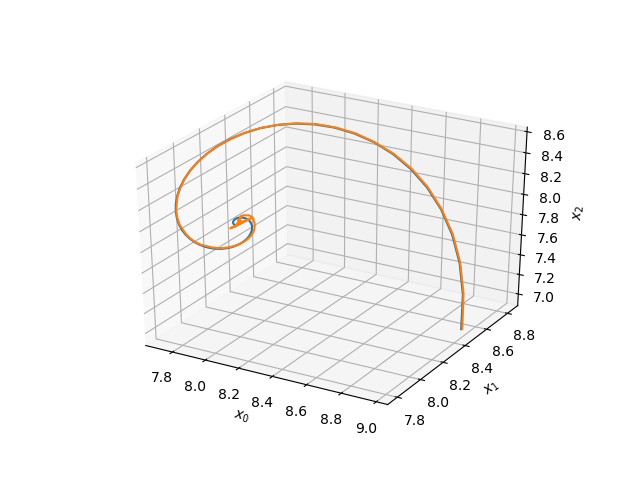

<IPython.core.display.Javascript object>


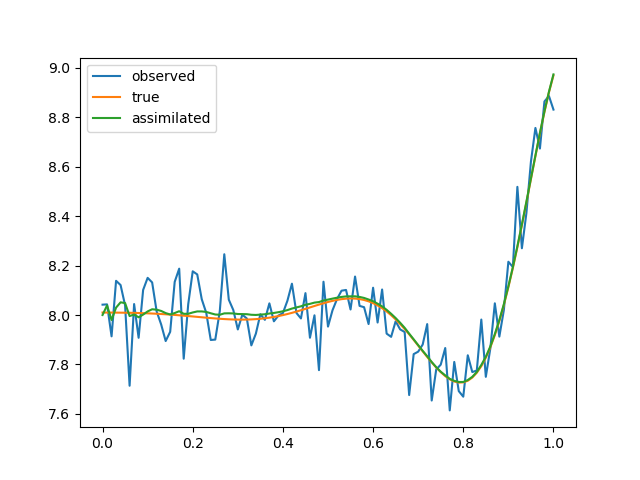

<IPython.core.display.Javascript object>


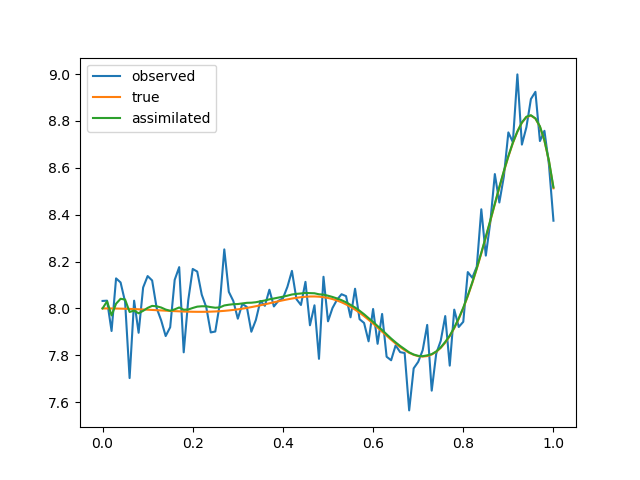

<IPython.core.display.Javascript object>


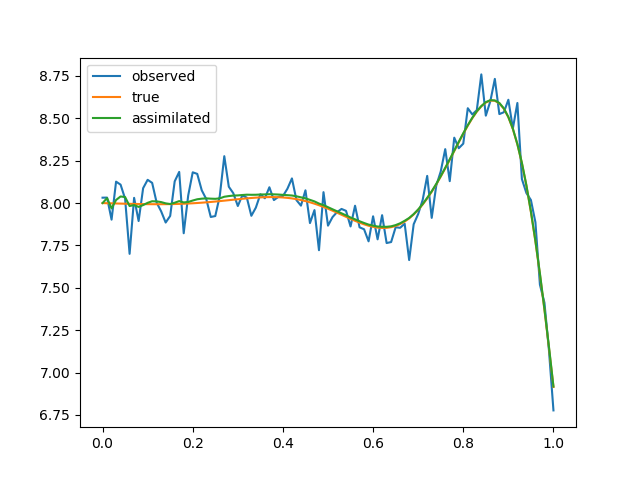

<IPython.core.display.Javascript object>


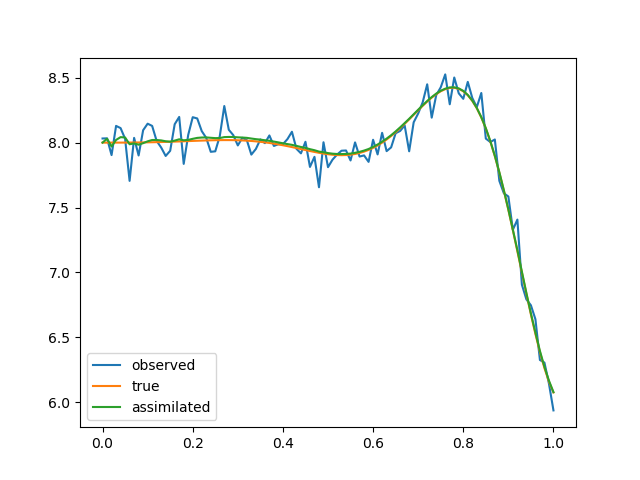

<IPython.core.display.Javascript object>


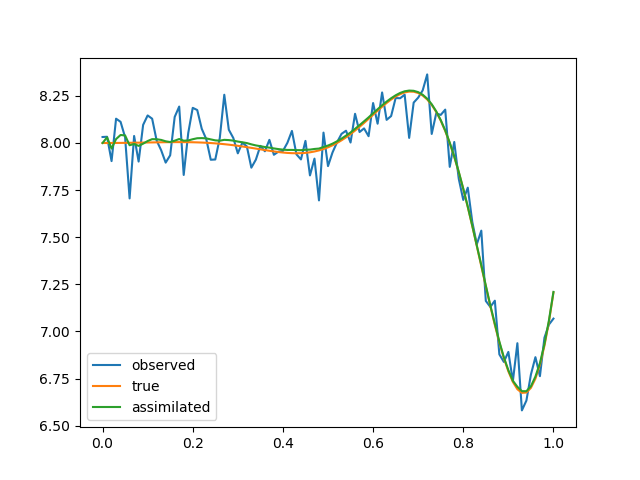

<IPython.core.display.Javascript object>


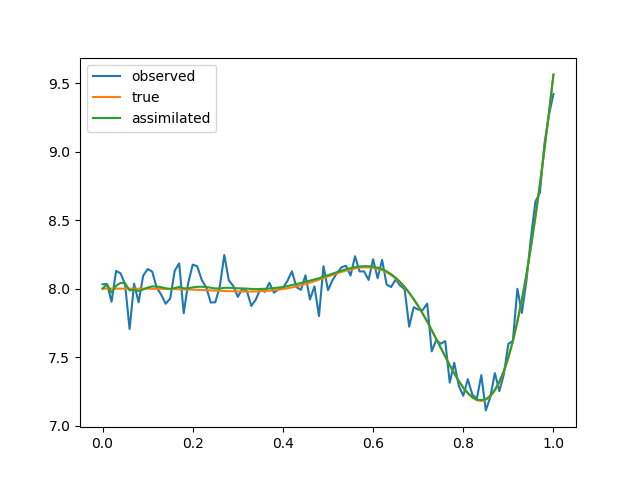

<IPython.core.display.Javascript object>


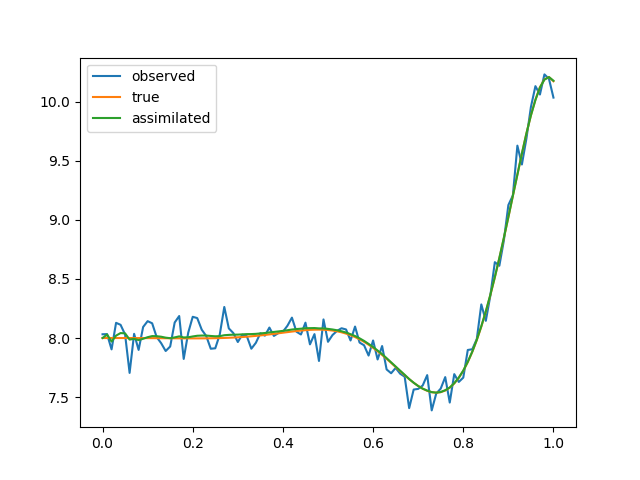

<IPython.core.display.Javascript object>


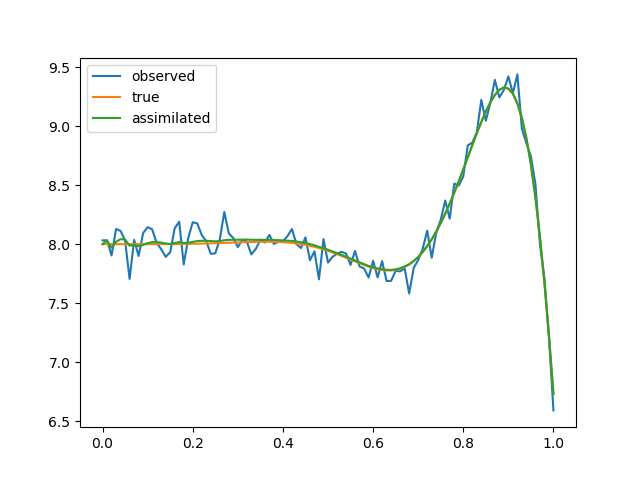

<IPython.core.display.Javascript object>


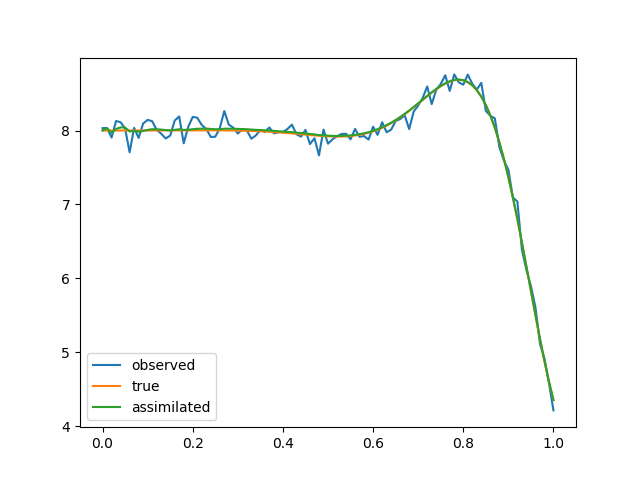

<IPython.core.display.Javascript object>


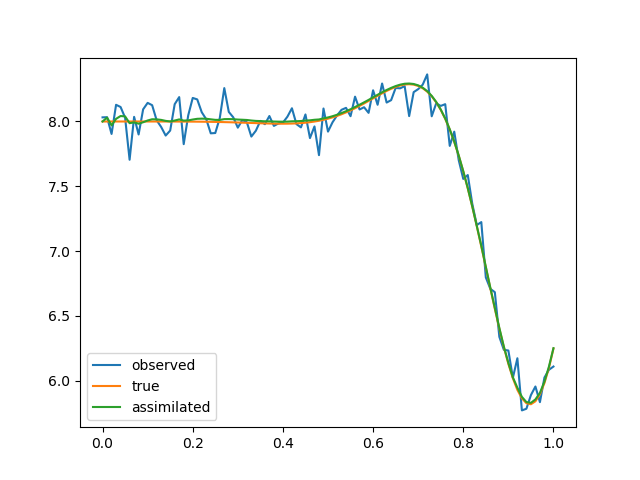

<IPython.core.display.Javascript object>


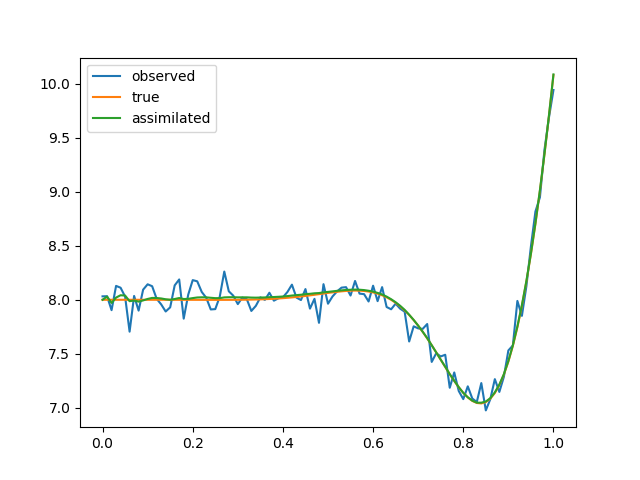

<IPython.core.display.Javascript object>


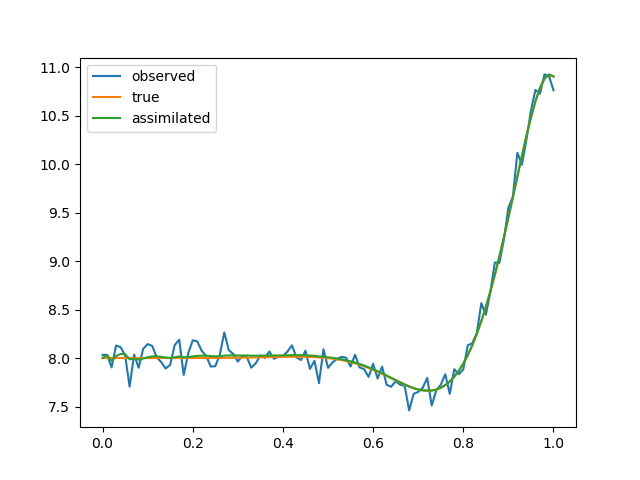

<IPython.core.display.Javascript object>


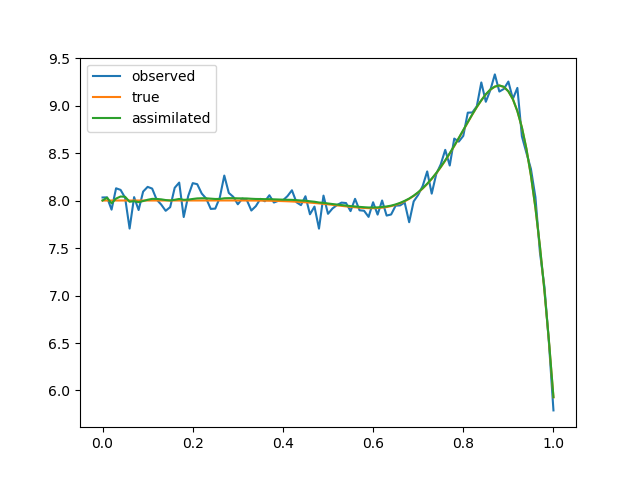

<IPython.core.display.Javascript object>


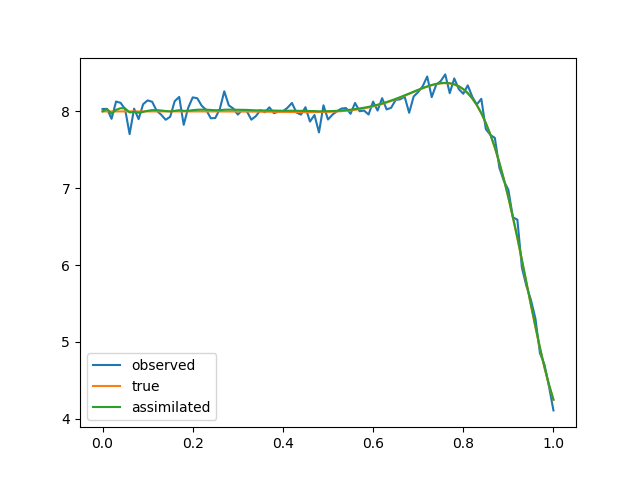

<IPython.core.display.Javascript object>


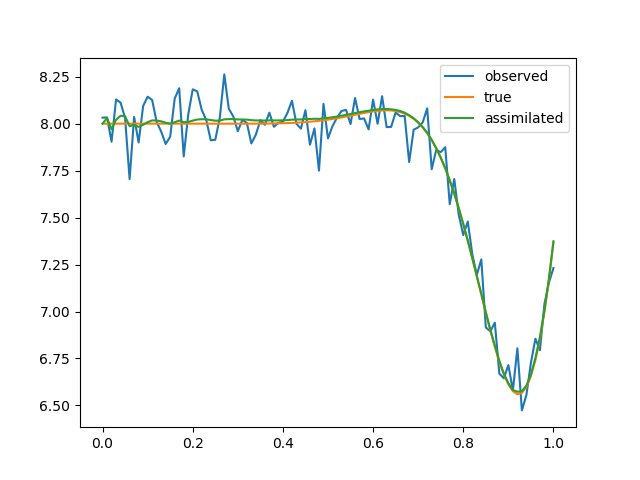

<IPython.core.display.Javascript object>


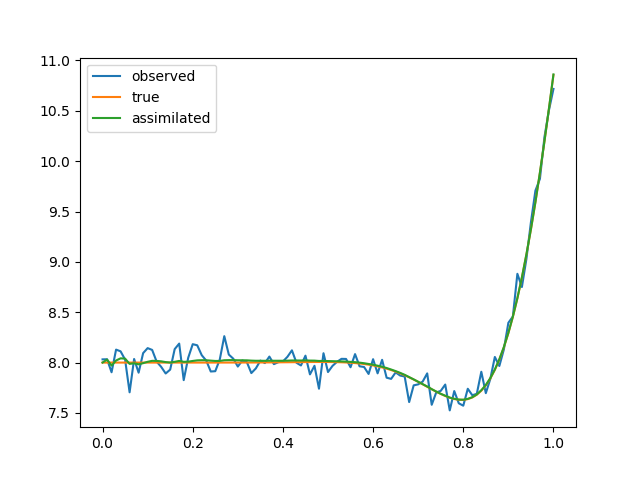

<IPython.core.display.Javascript object>


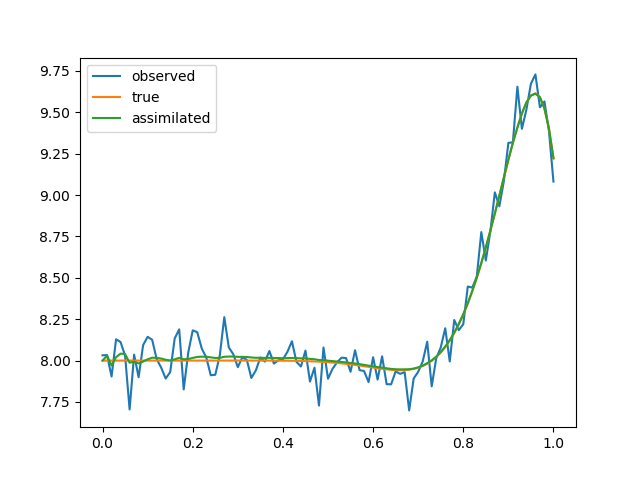

<IPython.core.display.Javascript object>


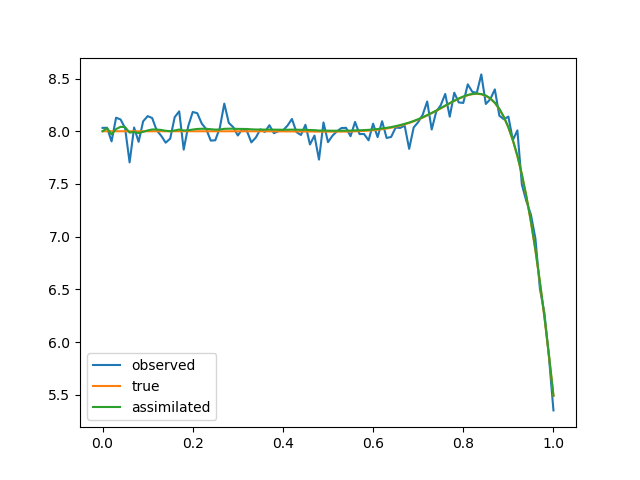

<IPython.core.display.Javascript object>


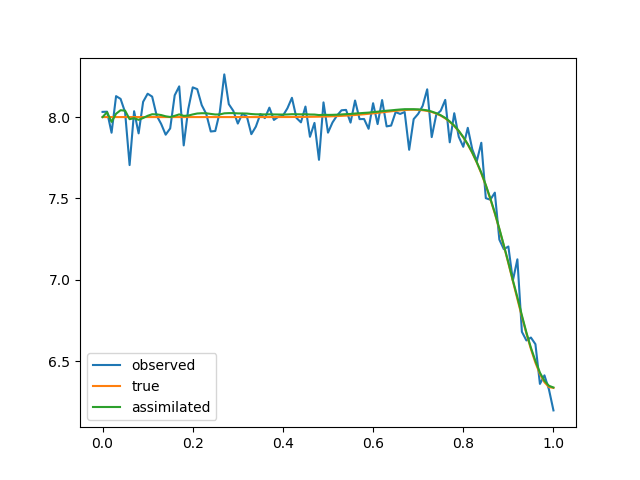

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


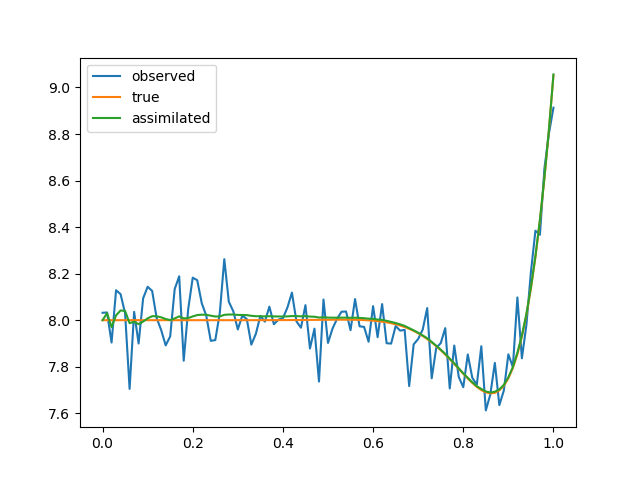

<IPython.core.display.Javascript object>


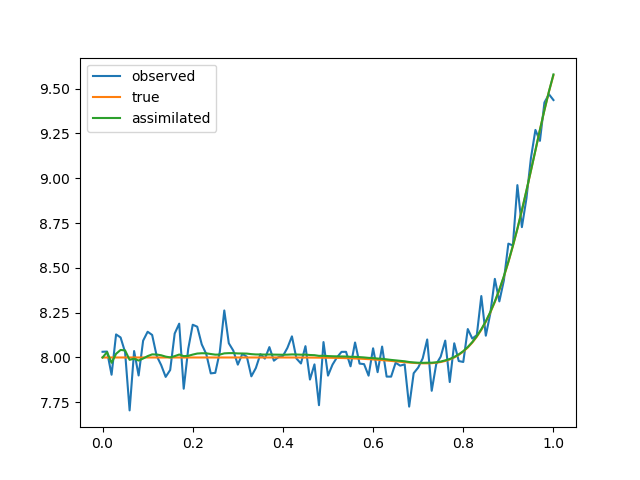

<IPython.core.display.Javascript object>


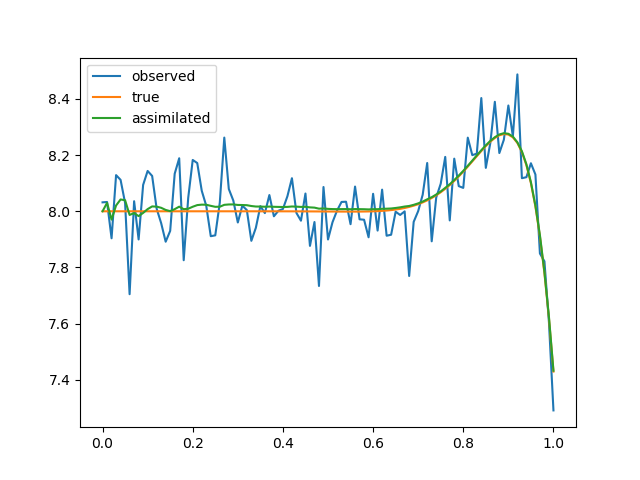

<IPython.core.display.Javascript object>


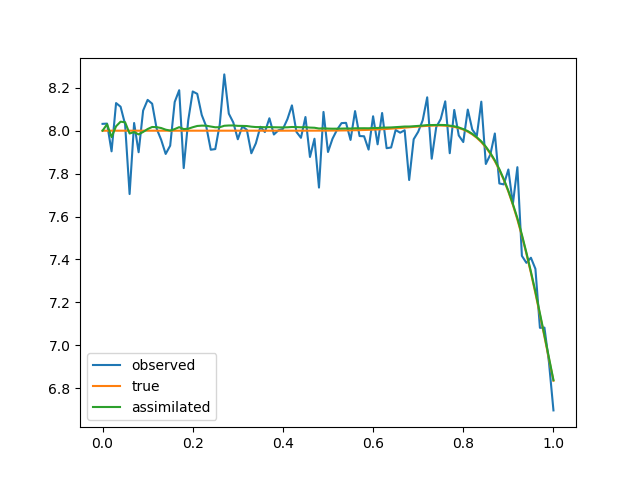

<IPython.core.display.Javascript object>


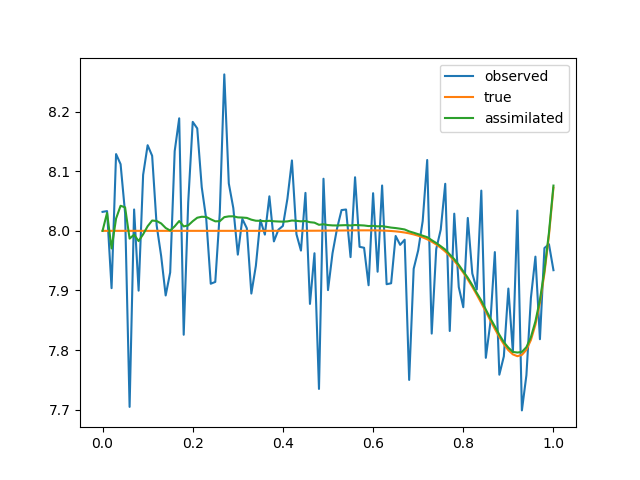

<IPython.core.display.Javascript object>


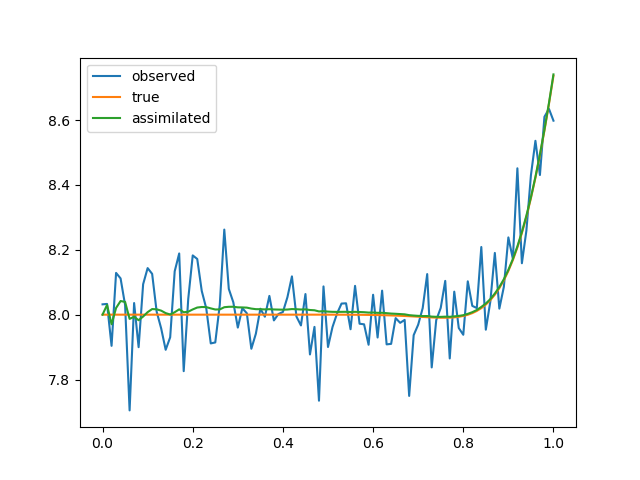

<IPython.core.display.Javascript object>


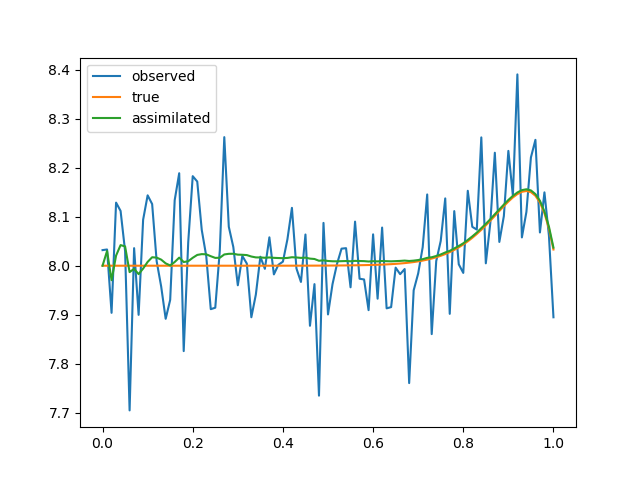

<IPython.core.display.Javascript object>


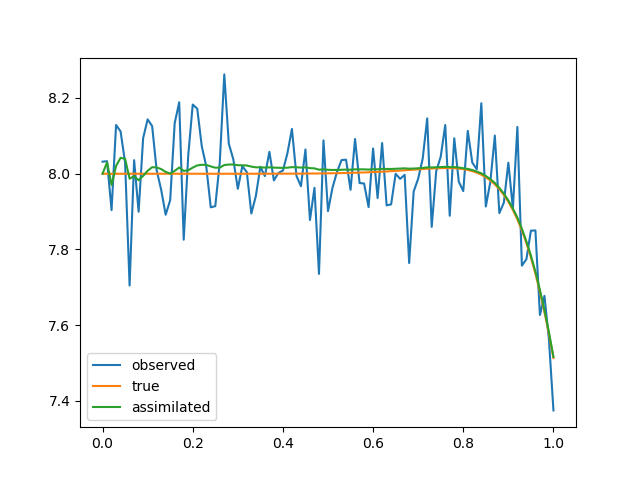

<IPython.core.display.Javascript object>


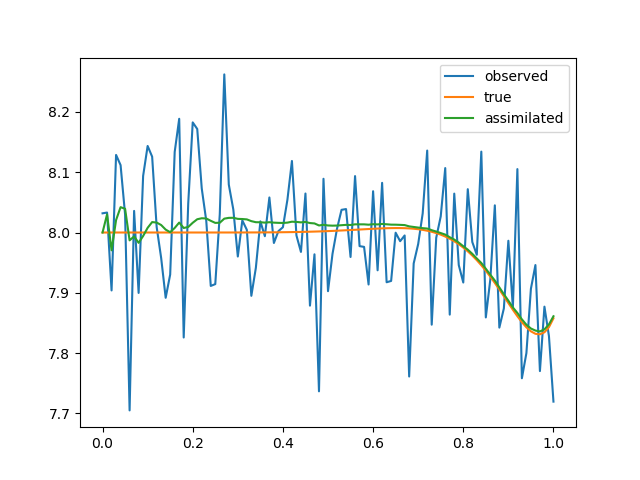

<IPython.core.display.Javascript object>


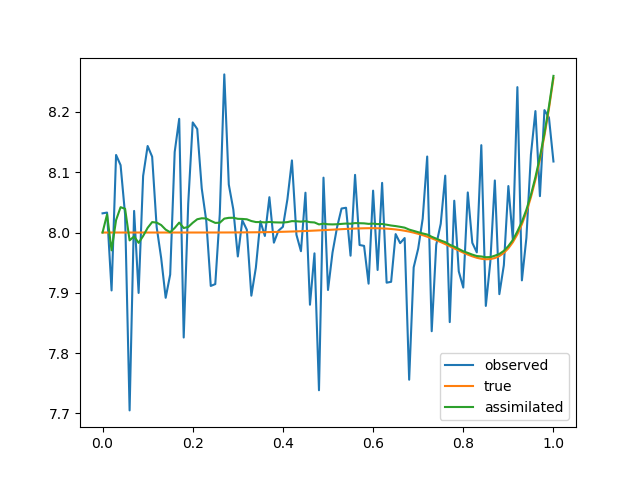

<IPython.core.display.Javascript object>


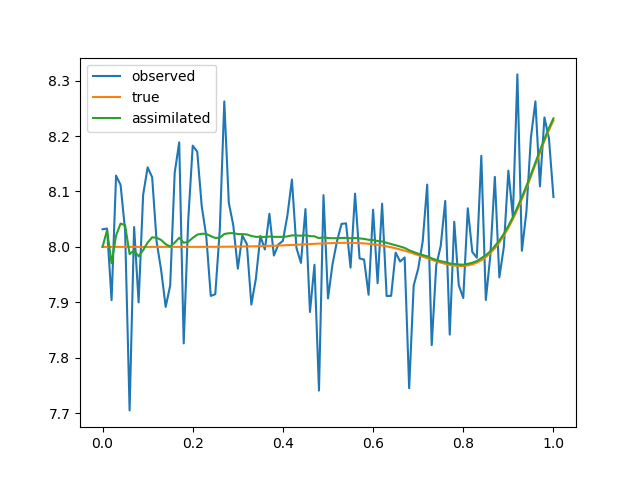

<IPython.core.display.Javascript object>


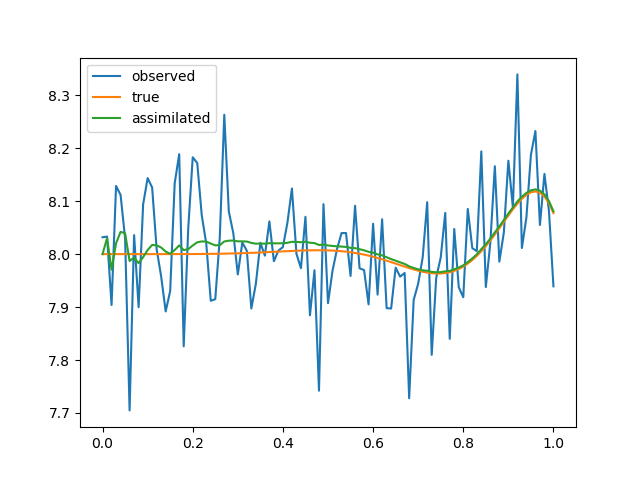

<IPython.core.display.Javascript object>


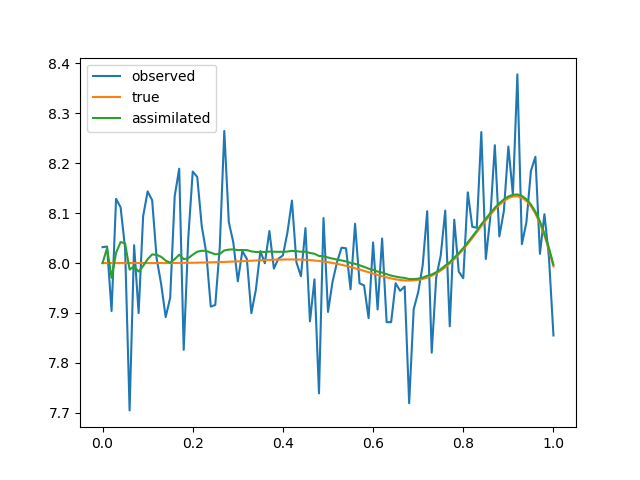

<IPython.core.display.Javascript object>


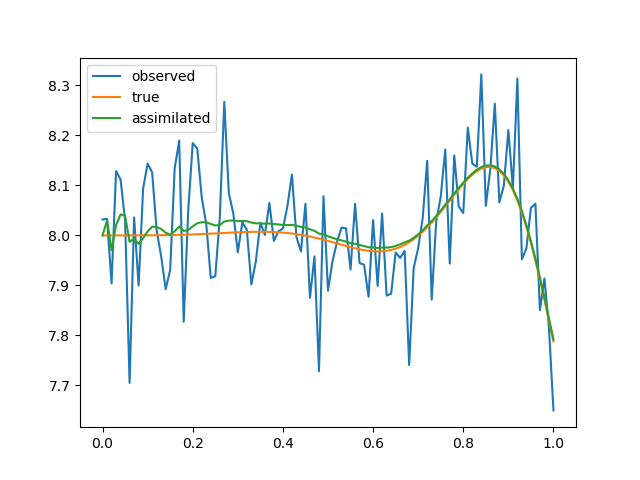

<IPython.core.display.Javascript object>


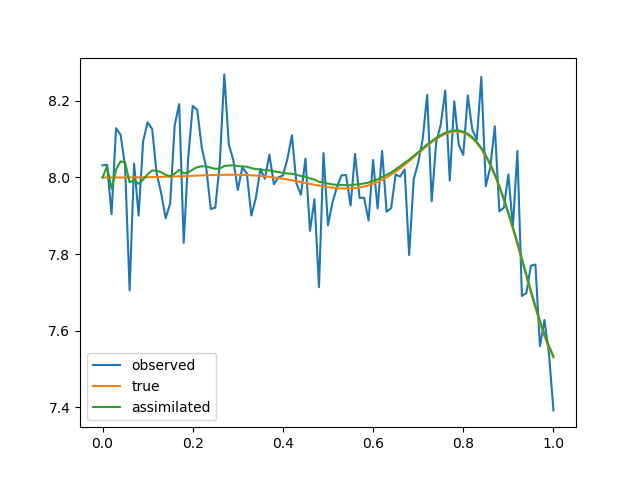

<IPython.core.display.Javascript object>


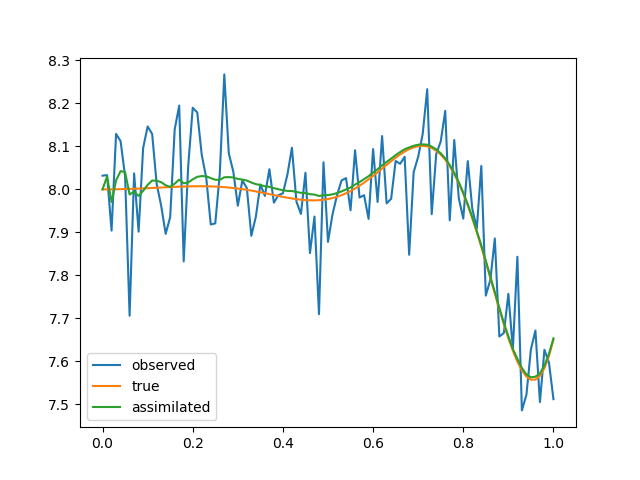

<IPython.core.display.Javascript object>


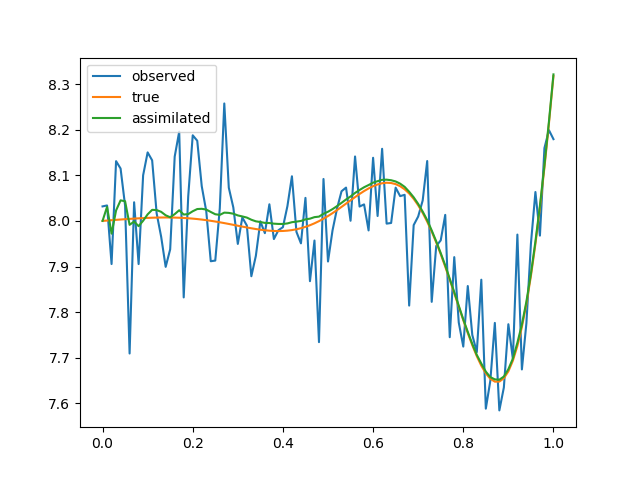

In [5]:
N = 36
F = 8
T = 1.
dt = 0.01
steps = int(T/dt) + 1
stddev = 0.1

R = np.zeros((N, N))
np.fill_diagonal(R, 0.1)

lorenz = Lorenz96(N, F)
rk4 = RK4(N, dt)
rk4matrix = RK4Matrix(N, N, dt)

t = np.arange(0., T + dt, dt)

x = np.zeros((steps, N))
x[0] = F * np.ones(N)
x[0][0] += 0.01

true_orbit = rk4.orbit(lorenz.gradient, 0., x[0], T)
y = rk4.observed(lorenz.gradient, 0., x[0], T, stddev)
# plot_orbit(y)

x[0] = F * np.ones(N)
#x[0][1] += 2.

P = np.zeros((steps, N, N))
np.fill_diagonal(P[0], 1)

kfstep = KFstep(lorenz, rk4, rk4matrix, N, dt, R)
kf = KF(kfstep, T, dt, x, P, y)

kf.filtering()
# plot_orbit(kf.x)

compare_orbit(true_orbit, kf.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t,[item[j] for item in y], label='observed')
    plt.plot(t,[item[j] for item in true_orbit], label='true')
    plt.plot(t,[item[j] for item in kf.x], label='assimilated')
    plt.legend()
    plt.show()